In [1]:
from math import sqrt
from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

### 데이터 로드

In [2]:
# dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/꽃피는하루_stat.csv', header=0, index_col=0)
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/미스터리튜브_stat.csv', header=0)
dataset

,searchDate,dailyViewCount,subscriberCount,videoCount,favorablePercent,activePercent
0,2020-02-14,19743,52200,17,0,54
1,2020-02-15,23929,52300,18,0,57
2,2020-02-16,26015,52500,18,0,58
3,2020-02-17,25312,52600,18,0,58
4,2020-02-18,25040,52800,18,0,57
...,...,...,...,...,...,...
364,2021-02-12,63144,86300,73,94,55
365,2021-02-13,86230,86700,74,94,56
366,2021-02-14,59113,87000,74,94,57
367,2021-02-15,68970,87400,75,94,57


In [3]:
# 데이터셋 컬럼 순서 변경
dataset = dataset[['dailyViewCount', 'videoCount', 'favorablePercent', 'activePercent', 'subscriberCount']]
dataset

,dailyViewCount,videoCount,favorablePercent,activePercent,subscriberCount
0,19743,17,0,54,52200
1,23929,18,0,57,52300
2,26015,18,0,58,52500
3,25312,18,0,58,52600
4,25040,18,0,57,52800
...,...,...,...,...,...
364,63144,73,94,55,86300
365,86230,74,94,56,86700
366,59113,74,94,57,87000
367,68970,75,94,57,87400


In [4]:
values = dataset.values
# 값들을 실수형으로 변환
values = values.astype('float32')

### 데이터 시각화

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f581147c710>,
      dtype=object)

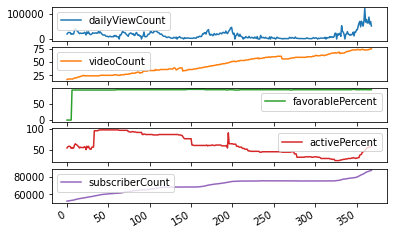

In [5]:
dataset.plot(subplots=True)

### 데이터 표준화

In [6]:
# data_mean = dataset.mean(axis=0)
# data_std = dataset.std(axis=0)
# dataset = (dataset-data_mean)/data_std

### 데이터 스케일링

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [8]:
values

array([[1.9743e+04, 1.7000e+01, 0.0000e+00, 5.4000e+01, 5.2200e+04],
       [2.3929e+04, 1.8000e+01, 0.0000e+00, 5.7000e+01, 5.2300e+04],
       [2.6015e+04, 1.8000e+01, 0.0000e+00, 5.8000e+01, 5.2500e+04],
       ...,
       [5.9113e+04, 7.4000e+01, 9.4000e+01, 5.7000e+01, 8.7000e+04],
       [6.8970e+04, 7.5000e+01, 9.4000e+01, 5.7000e+01, 8.7400e+04],
       [5.1223e+04, 7.5000e+01, 9.4000e+01, 5.8000e+01, 8.7600e+04]],
      dtype=float32)

In [9]:
# standardScaler = StandardScaler()
# print(standardScaler.fit(values))
# scaled = standardScaler.transform(values)

In [10]:
scaled

array([[0.16352071, 0.        , 0.        , 0.4109589 , 0.        ],
       [0.19819112, 0.01724136, 0.        , 0.4520548 , 0.0028249 ],
       [0.21546833, 0.01724136, 0.        , 0.46575344, 0.00847459],
       ...,
       [0.48960137, 0.98275864, 0.9894737 , 0.4520548 , 0.9830508 ],
       [0.5712416 , 1.        , 0.9894737 , 0.4520548 , 0.9943502 ],
       [0.42425272, 1.        , 0.9894737 , 0.46575344, 1.        ]],
      dtype=float32)

In [11]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()

  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
          names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
          names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names

  # drop rows with NaN values
  if dropnan:
      agg.dropna(inplace=True)

  return agg

In [12]:
reframed = series_to_supervised(scaled, 10, 1)
# reframed = series_to_supervised(values, 1, 1)

# reframed

In [13]:
reframed

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var1(t-9),var2(t-9),var3(t-9),var4(t-9),var5(t-9),var1(t-8),var2(t-8),var3(t-8),var4(t-8),var5(t-8),var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
10,0.163521,0.000000,0.000000,0.410959,0.000000,0.198191,0.017241,0.000000,0.452055,0.002825,0.215468,0.017241,0.000000,0.465753,0.008475,0.209646,0.017241,0.000000,0.465753,0.011299,0.207393,0.017241,0.000000,0.452055,0.016949,0.152712,0.017241,0.000000,0.397260,0.019774,0.175398,0.017241,0.978947,0.424658,0.025424,0.156688,0.017241,0.978947,0.397260,0.031073,0.167794,0.034483,0.978947,0.410959,0.033898,0.276204,0.051724,0.978947,0.506849,0.039548,0.330338,0.051724,0.978947,0.547945,0.050847
11,0.198191,0.017241,0.000000,0.452055,0.002825,0.215468,0.017241,0.000000,0.465753,0.008475,0.209646,0.017241,0.000000,0.465753,0.011299,0.207393,0.017241,0.000000,0.452055,0.016949,0.152712,0.017241,0.000000,0.397260,0.019774,0.175398,0.017241,0.978947,0.424658,0.025424,0.156688,0.017241,0.978947,0.397260,0.031073,0.167794,0.034483,0.978947,0.410959,0.033898,0.276204,0.051724,0.978947,0.506849,0.039548,0.330338,0.051724,0.978947,0.547945,0.050847,0.289969,0.051724,0.978947,0.520548,0.059322
12,0.215468,0.017241,0.000000,0.465753,0.008475,0.209646,0.017241,0.000000,0.465753,0.011299,0.207393,0.017241,0.000000,0.452055,0.016949,0.152712,0.017241,0.000000,0.397260,0.019774,0.175398,0.017241,0.978947,0.424658,0.025424,0.156688,0.017241,0.978947,0.397260,0.031073,0.167794,0.034483,0.978947,0.410959,0.033898,0.276204,0.051724,0.978947,0.506849,0.039548,0.330338,0.051724,0.978947,0.547945,0.050847,0.289969,0.051724,0.978947,0.520548,0.059322,0.271077,0.068965,0.978947,0.506849,0.064972
13,0.209646,0.017241,0.000000,0.465753,0.011299,0.207393,0.017241,0.000000,0.452055,0.016949,0.152712,0.017241,0.000000,0.397260,0.019774,0.175398,0.017241,0.978947,0.424658,0.025424,0.156688,0.017241,0.978947,0.397260,0.031073,0.167794,0.034483,0.978947,0.410959,0.033898,0.276204,0.051724,0.978947,0.506849,0.039548,0.330338,0.051724,0.978947,0.547945,0.050847,0.289969,0.051724,0.978947,0.520548,0.059322,0.271077,0.068965,0.978947,0.506849,0.064972,0.245037,0.068965,0.978947,0.479452,0.073446
14,0.207393,0.017241,0.000000,0.452055,0.016949,0.152712,0.017241,0.000000,0.397260,0.019774,0.175398,0.017241,0.978947,0.424658,0.025424,0.156688,0.017241,0.978947,0.397260,0.031073,0.167794,0.034483,0.978947,0.410959,0.033898,0.276204,0.051724,0.978947,0.506849,0.039548,0.330338,0.051724,0.978947,0.547945,0.050847,0.289969,0.051724,0.978947,0.520548,0.059322,0.271077,0.068965,0.978947,0.506849,0.064972,0.245037,0.068965,0.978947,0.479452,0.073446,0.206043,0.086207,0.978947,0.452055,0.076271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,0.572857,0.965517,0.989474,0.178082,0.833333,0.396390,0.965517,1.000000,0.191781,0.847458,0.579889,0.982759,0.989474,0.205479,0.861582,0.513223,0.982759,0.989474,0.273973,0.872881,0.421627,0.982759,0.989474,0.287671,0.881356,0.593480,0.965517,0.989474,0.301370,0.895480,1.000000,0.965517,1.000000,0.328767,0.915254,0.551132,0.965517,0.989474,0.356164,0.932203,0.635563,0.965517,0.989474,0.397260,0.946328,0.522955,0.965517,0.989474,0.410959,0.954802,0.522988,0.965517,0.989474,0.424658,0.963277
365,0.396390,0.965517,1.000000,0.191781,0.847458,0.579889,0.982759,0.989474,0.205479,0.861582,0.513223,0.982759,0.989474,0.273973,0.872881,0.421627,0.982759,0.989474,0.287671,0.881356,0.593480,0.965517,0.989474,0.301370,0.895480,1.000000,0.9

In [14]:
# train/test 데이터로 나눔
values = reframed.values
n_train_hours = int(len(values)*0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [15]:
# 입력값과 출력값으로 분리
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape)

(251, 54) (251,)


In [16]:
# 3D 값으로 reshape
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(251, 1, 54) (251,) (108, 1, 54) (108,)


### 모델 디자인

In [17]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [18]:
history = model.fit(train_X, train_y, epochs= 150, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/150
4/4 - 3s - loss: 0.2971 - val_loss: 0.3691
Epoch 2/150
4/4 - 0s - loss: 0.0969 - val_loss: 0.1595
Epoch 3/150
4/4 - 0s - loss: 0.1121 - val_loss: 0.0474
Epoch 4/150
4/4 - 0s - loss: 0.1478 - val_loss: 0.0428
Epoch 5/150
4/4 - 0s - loss: 0.1116 - val_loss: 0.1070
Epoch 6/150
4/4 - 0s - loss: 0.0805 - val_loss: 0.1282
Epoch 7/150
4/4 - 0s - loss: 0.0680 - val_loss: 0.0866
Epoch 8/150
4/4 - 0s - loss: 0.0359 - val_loss: 0.0282
Epoch 9/150
4/4 - 0s - loss: 0.0494 - val_loss: 0.0501
Epoch 10/150
4/4 - 0s - loss: 0.0280 - val_loss: 0.0282
Epoch 11/150
4/4 - 0s - loss: 0.0454 - val_loss: 0.0272
Epoch 12/150
4/4 - 0s - loss: 0.0376 - val_loss: 0.0537
Epoch 13/150
4/4 - 0s - loss: 0.0262 - val_loss: 0.0404
Epoch 14/150
4/4 - 0s - loss: 0.0281 - val_loss: 0.0256
Epoch 15/150
4/4 - 0s - loss: 0.0263 - val_loss: 0.0310
Epoch 16/150
4/4 - 0s - loss: 0.0204 - val_loss: 0.0238
Epoch 17/150
4/4 - 0s - loss: 0.0240 - val_loss: 0.0235
Epoch 18/150
4/4 - 0s - loss: 0.0191 - val_loss: 0.0223
E

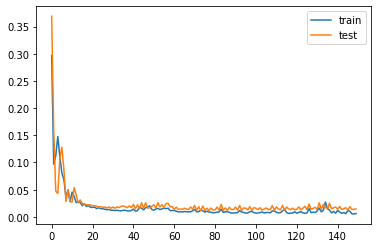

In [19]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [20]:
# scaler.inverse_transform(yhat)


In [21]:
# make a prediction
yhat = model.predict(test_X)

In [22]:
yhat.shape

(108, 1)

In [23]:
# make a prediction
# yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# # invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat) # 트랜스폼 원래대로 되돌리는 과정이 에러남
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y) # # 트랜스폼 원래대로 되돌리는 과정이 에러남2
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
rmse

0.021717349944682853

In [24]:
yhat.shape

(108, 1)

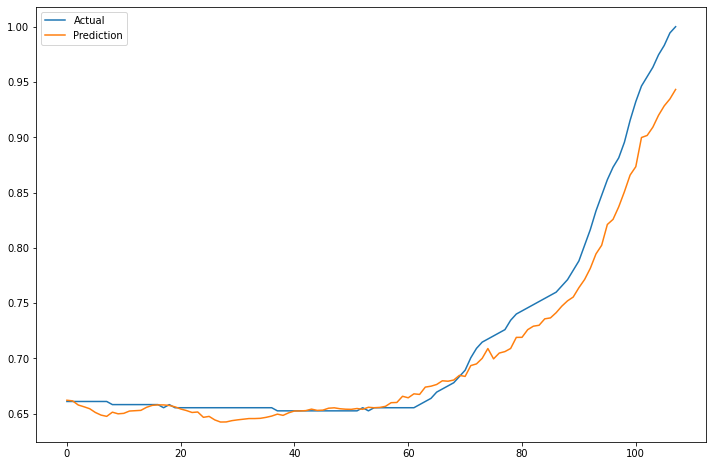

In [25]:
fig = plt.figure(facecolor='white', figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(inv_y, label='Actual')
ax.plot(inv_yhat, label='Prediction')
ax.legend()
plt.show()

In [26]:
def plot(self, model=None, plot_col='subscriberCount', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

In [27]:
model.plot = plot
model.plot

<function __main__.plot>

https://financedata.github.io/posts/faq_matplotlib_highlight.html